In [1]:
import numpy as np
from numpy.linalg.linalg import norm
#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
#import tensorflow as tf
#from tensorflow.keras.models import Model
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Activation, Flatten
#from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, LayerNormalization
#from keras.optimizers import Adam
#from keras.optimizers import RMSprop
#from keras.regularizers import l2
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.markers import MarkerStyle
import cartopy.crs as ccrs
import cartopy.feature as cfeaturel
import pandas as pd


# データの読み込み
data = np.load('/work/gi55/i55233/data/results/bsiso_eeof/prepro_anomaly_7vals.npz')
print('data = ', data.files)

data =  ['lat', 'lon', 'time', 'real_time', 'olr', 'u850', 'v850', 'u200', 'v200', 'h850', 'pr_wtr']


In [2]:
lat = data['lat'][24:49]
lon = data['lon']
olr = data['olr'][80:,24:49,:]
#u850 = data['u850'][80:,24:49,:]
#v850 = data['v850'][80:,24:49,:]
#u200 = data['u200'][80:,24:49,:]
#v200 = data['v200'][80:,24:49,:]
#h850 = data['h850'][80:,24:49,:]
#pr_wtr = data['pr_wtr'][80:,24:49,:]
time = data['time'][80+10:]  # 射影後にデータが10日進むため、時刻の方を前進させておく
real_time = pd.to_datetime(time, unit='h', origin=pd.Timestamp('1800-01-01')) # 時刻をdatetime型に変換
#print(lat.shape, lon.shape, olr.shape, u850.shape, v850.shape, u200.shape, v200.shape, h850.shape, pr_wtr.shape)
print(real_time[0], real_time[-1])

1979-04-01 00:00:00 2022-12-31 00:00:00


In [3]:
# 標準化処理
def normalization(data):
  data_mean = np.mean(data, axis=0)
  data_std  = np.std(data, axis=0)
  data_norm = (data - data_mean) / data_std
  print('Raw Data        = ', data.max(), data.min())
  print('Normalized Data = ', data_norm.max(), data_norm.min())
  del data_mean, data_std
  return data_norm

olr_norm  = normalization(olr)
#u850_norm = normalization(u850)
#v850_norm = normalization(v850)
#u200_norm = normalization(u200)
#v200_norm = normalization(v200)
#h850_norm = normalization(h850)
#pr_wtr_norm = normalization(pr_wtr)

Raw Data        =  110.6346296477856 -163.06319252604578
Normalized Data =  8.610244733289218 -15.696228824469003


In [4]:
# bsiso index (eEOF) 読み込み
data_file = '/work/gi55/i55233/data/archive/kikuchi_bsiso_index.dat'

year    = np.loadtxt(data_file, usecols = 0, dtype = int)
month   = np.loadtxt(data_file, usecols = 1, dtype = int)
day     = np.loadtxt(data_file, usecols = 2, dtype = int)
PC_bp     = np.loadtxt(data_file, usecols = [3, 4])
#PCy     = np.loadtxt(data_file, usecols = 4)
phase   = np.loadtxt(data_file, usecols = 5, dtype = int)
Amp_nrm_bsiso = np.loadtxt(data_file, usecols = 6, dtype = float)
#index = np.loadtxt(data_file)

print('month = ', month.shape)
print('phase = ', phase.shape)
print( 'PC = ', PC_bp.shape)
print('Amp_nrm_bsiso = ', Amp_nrm_bsiso.shape)
print(year, month, day)

month =  (15556,)
phase =  (15556,)
PC =  (15556, 2)
Amp_nrm_bsiso =  (15556,)
[1979 1979 1979 ... 2021 2021 2021] [ 3  3  3 ... 10 10 10] [22 23 24 ... 20 21 22]


In [5]:
# 全て一律にずらしたあと、インデクシングする
lead_time = 0
multi_forcast = False
if multi_forcast == True:
  output_shape = 2 * (lead_time + 1)
else:
  output_shape = 2
print('output shape = ', output_shape)

amp = Amp_nrm_bsiso[10:-lead_time-1]
ph = phase[10:-lead_time-1]
yy = year[10:-lead_time-1]
mm = month[10:-lead_time-1]
dd = day[10:-lead_time-1]
rt = real_time[10:-lead_time-1]
# 教師データは前進させる
if multi_forcast == True:
  sup_data = []
  for j in range(lead_time+1):
    sup_j = PC[10+j:-lead_time-1+j]
    sup_data.append(sup_j)
  sup_data = np.array(sup_data).transpose(1,0,2).reshape(-1, output_shape)
else:
  sup_data = PC[10+lead_time:]
print(sup_data.shape)


# 入力データの前処理
def preprocess(data):
  ipt_lag0  = data[10:-lead_time-1]
  ipt_lag5  = data[5:-lead_time-6]
  ipt_lag10 = data[:-lead_time-11]

  # =========
  # 訓練データの作成(通年データとする)
  idx = np.where((yy <= 2014))[0]
  ipt_lag0_train = ipt_lag0[idx]
  ipt_lag5_train = ipt_lag5[idx]
  ipt_lag10_train = ipt_lag10[idx]
  #ipt_train = np.concatenate([ipt_lag0_train, ipt_lag5_train, ipt_lag10_train], 1)
  ipt_train = np.stack([ipt_lag0_train, ipt_lag5_train, ipt_lag10_train], 3)

  # 検証データの作成
  idx = np.where((yy > 2014))[0]
  ipt_lag0_test = ipt_lag0[idx]
  ipt_lag5_test = ipt_lag5[idx]
  ipt_lag10_test = ipt_lag10[idx]
  #ipt_test = np.concatenate([ipt_lag0_test, ipt_lag5_test, ipt_lag10_test], 1)
  ipt_test = np.stack([ipt_lag0_test, ipt_lag5_test, ipt_lag10_test], 3)
  return ipt_train, ipt_test

olr_ipt_train, olr_ipt_test = preprocess(olr_norm)
#u850_ipt_train, u850_ipt_test = preprocess(u850_norm)
#v850_ipt_train, v850_ipt_test = preprocess(v850_norm)
#ipt_train = np.concatenate([olr_ipt_train, u850_ipt_train, v850_ipt_train], 3)
#ipt_test = np.concatenate([olr_ipt_test, u850_ipt_test, v850_ipt_test], 3)
#ipt_train, ipt_test = v850_ipt_train, v850_ipt_test

# その他のインデクシング
idx = np.where((yy <= 2014))[0]
sup_train = sup_data[idx]
idx = np.where((yy > 2014))[0]
sup_test = sup_data[idx]
amp = amp[idx]
ph = ph[idx]
yy = yy[idx]
mm = mm[idx]
dd = dd[idx]
rt = rt[idx]
#print(sup_test.shape, ipt_test.shape, ipt_train.shape, ph.shape, yy.shape, mm.shape, dd.shape)
#del olr_ipt_train, olr_ipt_test, u850_ipt_train, u850_ipt_test, v850_ipt_train, v850_ipt_test

output shape =  2


NameError: name 'PC' is not defined

# real-time 予測向けにデータを射影

In [6]:
X_10lag = olr[:-10].reshape(-1, 25*144)
X_5lag  = olr[5:-5].reshape(-1, 25*144)
X_0lag  = olr[10:].reshape(-1, 25*144)
# 空間方向に結合
X_total = np.concatenate([X_10lag, X_5lag, X_0lag], axis=1)
print('X_total = ',X_total.shape)

X_total =  (15981, 10800)


<Figure size 1200x900 with 0 Axes>

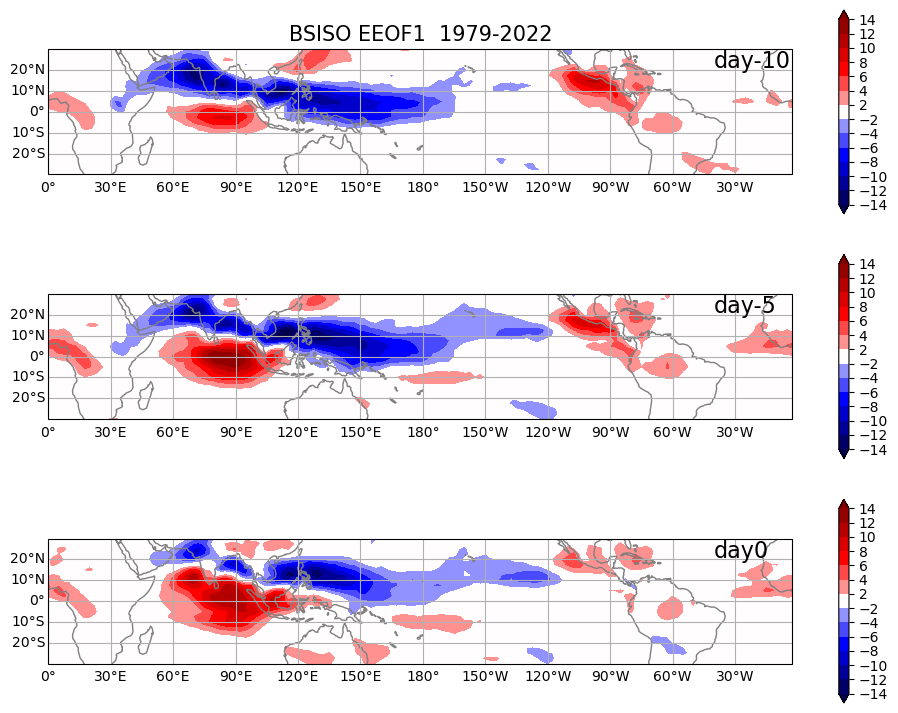

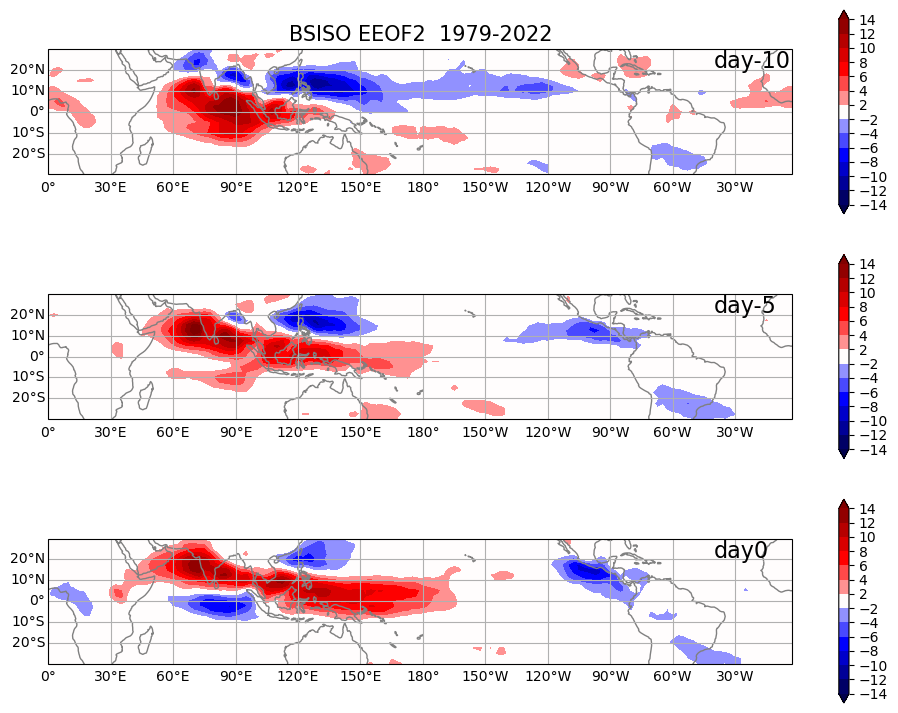

In [17]:
# データをEEOFに射影
df = np.load('/work/gi55/i55233/data/results/bsiso_eeof/eeof.npz')
print(df.files)
EEOF = df['EEOFs'].transpose(1,2,3,0)
EEOF_f = EEOF.reshape(-1, 25*144, 3)
EEOF_f = EEOF_f.reshape(-1, 3600*3)
print(EEOF.shape, EEOF_f.shape)
U = df['U']
print(U.shape, EEOF.shape)
rt_PCs = X_total @ U
print(rt_PCs.shape)
rt_PCs_norm = rt_PCs / rt_PCs.std(axis=0)[np.newaxis,:]
print(real_time.shape)

['lon', 'lat', 'time', 'EEOFs', 'PC', 'D', 'V', 's', 'U']


KeyboardInterrupt: 

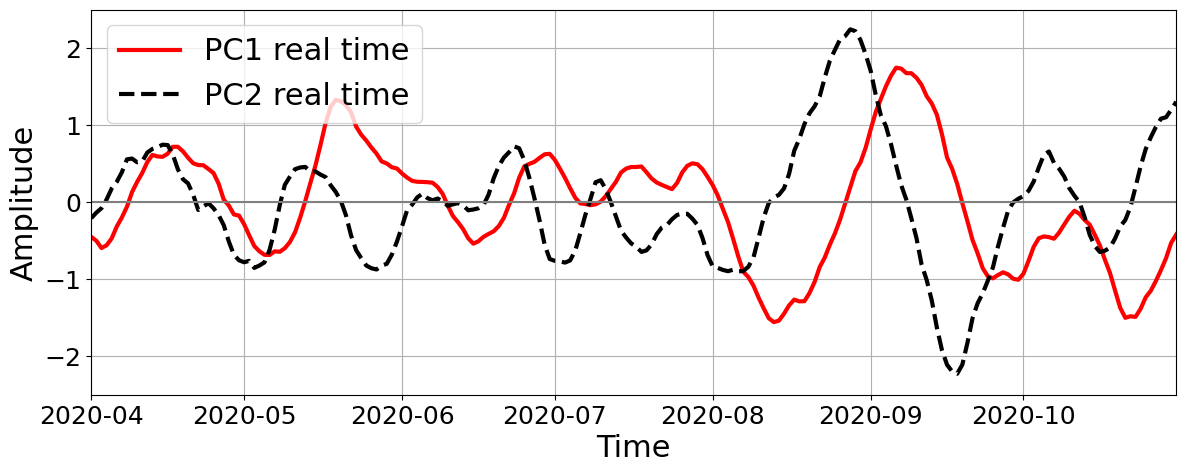

In [124]:
rt = real_time
idx = np.where((rt.year == 2020) & (rt.month <= 10) & (rt.month >= 4))[0] 
tt = rt[idx]
bp_PCs = PC_bp[10:]
plt.figure(figsize=(14,5))
#plt.plot(tt, bp_PCs[idx,1], label='PC1 band pass', color='k', linewidth=2, alpha=0.7)
#plt.plot(tt, bp_PCs[idx,0], linestyle='--', label='PC2 band pass', color='k', linewidth=2, alpha=0.7)
plt.plot(tt, -rt_PCs_norm[idx,0], label='PC1 real time', color='r', linewidth=3)
plt.plot(tt, rt_PCs_norm[idx,1], linestyle='--', label='PC2 real time', color='k', linewidth=3)
plt.hlines(0, tt[0], tt[-1], 'grey', linestyle='-')
plt.xlim(tt[0], tt[-1])
# メモリのフォントサイズの設定
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-2.5, 2.5)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Amplitude', fontsize=22)
#plt.legend(fontsize=20, loc='upper right', ncol=2)
plt.legend(fontsize=22, loc='upper left')
plt.grid()
plt.show()

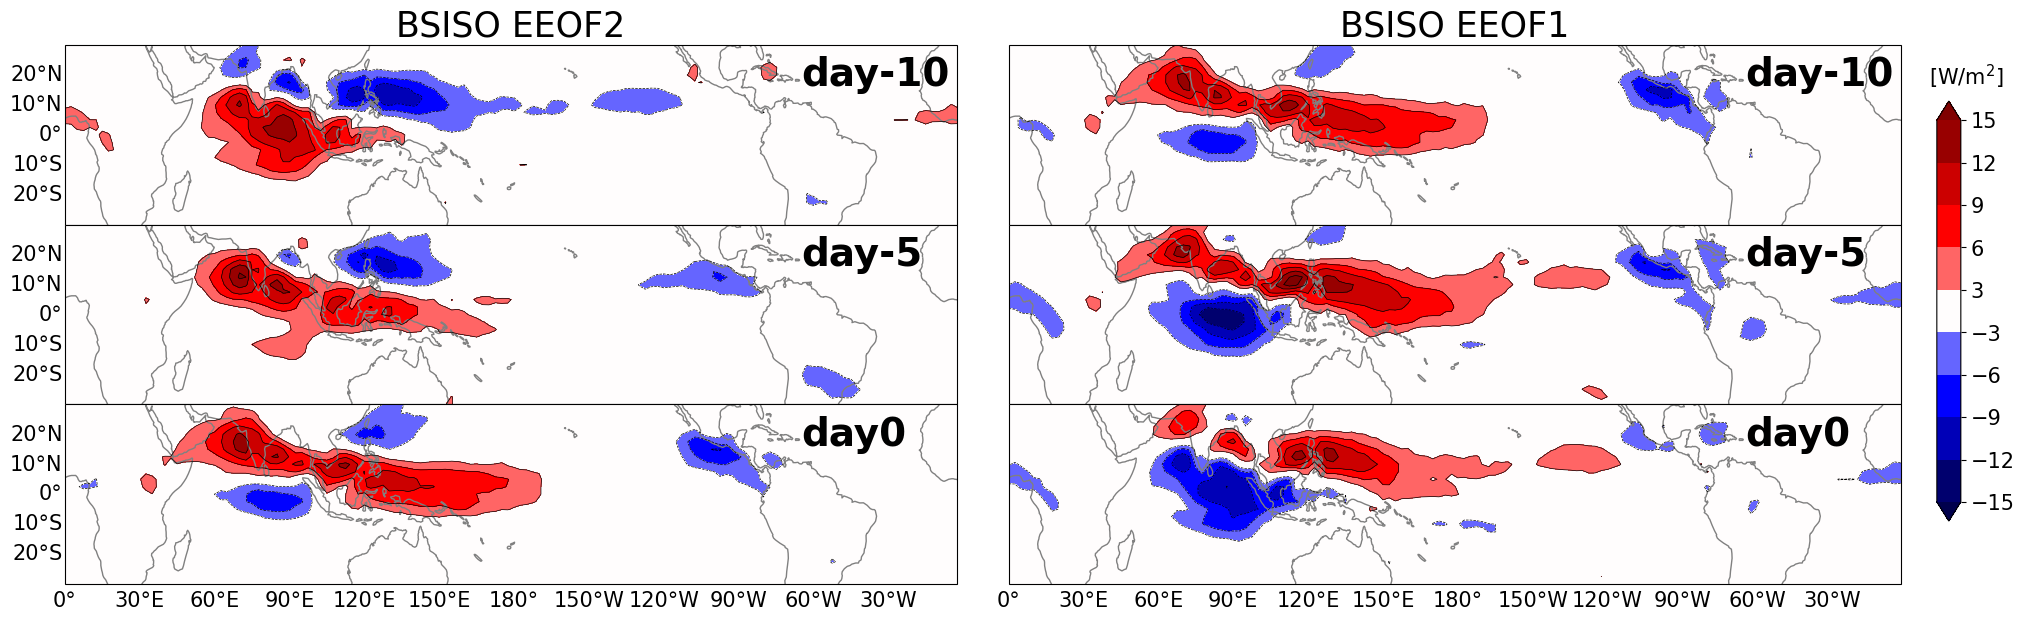

In [120]:
lag = ['day-10', 'day-5', 'day0']
num = [-15, -12, -9, -6, -3, 3, 6, 9, 12, 15]
sign = [-1, 1]
position = [2, 1] # EEOF1, 2 の位置を入れ替える
fig = plt.figure(figsize=(24, 7))
plt.subplots_adjust(wspace=0.03, hspace=0.0)
for i in range(1,3):
    for j in range(1,4):
        ax=fig.add_subplot(3,2,position[i-1]+2*(j-1), projection=ccrs.PlateCarree(central_longitude=180))
        #ax=fig.add_axes((0.05, 0.65-0.25*(j-1), 0.9, 0.3), projection=ccrs.PlateCarree(central_longitude=180))
        ax.set_extent([-180, 177.5, -30, 30], crs=ccrs.PlateCarree())    
        ax.set_aspect(1.2)     
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.0)
        gl.top_labels = False     # 上部の経度のラベルを消去
        if j != 3:
            gl.bottom_labels = False 
        if i != 2:
            gl.left_labels = False
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30)) # 経度線
        gl.ylocator = mticker.FixedLocator(np.arange(-30, 50, 10)) # 緯度線
        gl.xlabel_style = {'size': 15}
        gl.ylabel_style = {'size': 15}
        ax.coastlines(color='gray') 
        # データのプロット
        x, y = np.meshgrid(lon-180.0, lat) # 経度、緯度データ
        cntrf = ax.contourf(x, y, sign[i-1]*EEOF[i-1,:,:,j-1], num, cmap='seismic', extend='both')
        cntr = ax.contour(x, y, sign[i-1]*EEOF[i-1,:,:,j-1], num, colors='k', linewidths=.5)
        ax.axis((-180, 177.5, -30, 30))
        ax.text(115, 20, lag[j-1], fontsize=28, ha='left', va='center', fontweight='bold')
        if j == 1:
            ax.set_title('BSISO EEOF' + str(i), fontsize=25)
cbar = fig.add_axes([0.91, 0.2, 0.01, 0.6]) # 順に[左からの位置、下からの位置、横幅、縦幅]
cbar = fig.colorbar(cntrf, cax=cbar, ticks=num)
cbar.set_label('$\mathrm{[W/m^2]}$', rotation=0, y=1.15, labelpad=-35, fontsize=15)
cbar.ax.tick_params(labelsize=15)

In [25]:
np.savez('/home/maeda/data/bsiso_eeof/bsiso_rt-PCs.npz',rt_PCs=rt_PCs[:,:10], time=time)

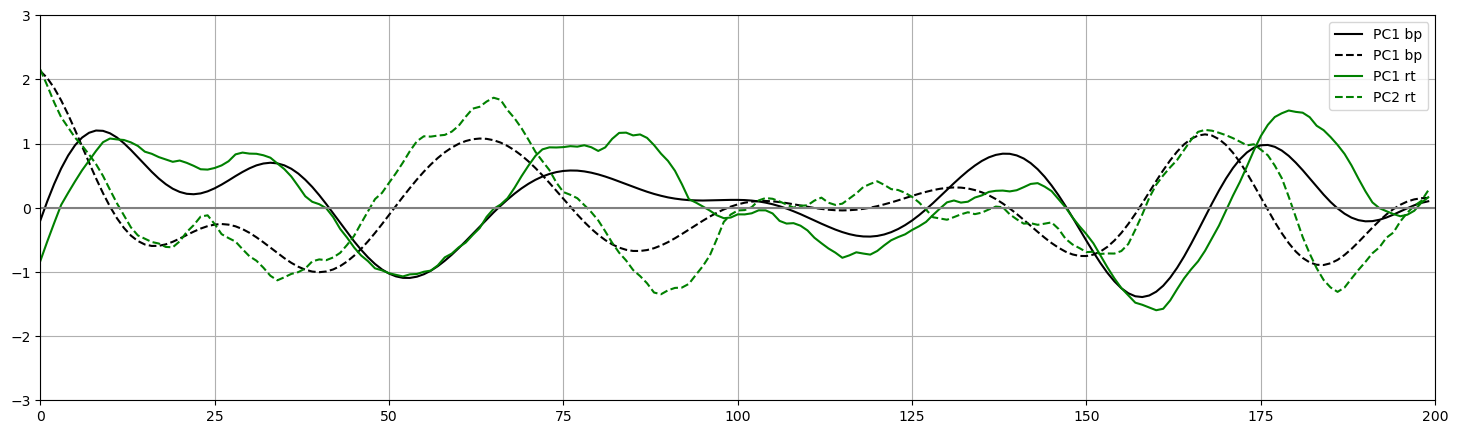

In [11]:
rt = real_time

bp_PCs = PC_bp[10:]
plt.figure(figsize=(18,5))
plt.plot(bp_PCs[200:400,1], label='PC1 bp', color='k')
plt.plot(bp_PCs[200:400,0], linestyle='--', label='PC1 bp', color='k')
plt.plot(-rt_PCs_norm[200:400,0], label='PC1 rt', color='g')
plt.plot(rt_PCs_norm[200:400,1], linestyle='--', label='PC2 rt', color='g')
plt.hlines(0, 0, 200, 'grey', linestyle='-')
plt.xlim(0, 200)
plt.ylim(-3, 3)
plt.legend()
plt.grid()
plt.show()